In [131]:
import numpy as np
import scipy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from typing import List, Tuple
import json
import heapq

from tqdm import tqdm
import seaborn as sns
sns.set_style("darkgrid")

In [5]:
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adhocmaster\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adhocmaster\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adhocmaster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adhocmaster\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adhocmaster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
# first convert inputs
from typing import List, Tuple
def treebankToWordnetPOS(treebankTag: str) -> str:
    if treebankTag.startswith("J"):
        return wordnet.ADJ
    if treebankTag.startswith("V"):
        return wordnet.VERB
    if treebankTag.startswith("N"):
        return wordnet.NOUN
    if treebankTag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize(inputs) -> List[Tuple[str, str]]:
    
    lemmatizer = WordNetLemmatizer()
    
    output = []
    for rawDoc in tqdm(inputs, desc = "lemmatizing", position=0):
        # break, get tags, remake sentence
        wordsAndTags = nltk.pos_tag(word_tokenize(rawDoc))
        lemmatizedWs = [lemmatizer.lemmatize(word, treebankToWordnetPOS(tag)) 
                            for word, tag in wordsAndTags]
        output.append(" ".join(lemmatizedWs))
    
    return output
    

In [144]:
df = pd.read_csv("../data/tmdb_5000_movies.csv")
df.set_index('title', inplace=True)
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
title,,,,,,,,,,,,,,,,,,,
Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
Spectre,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
The Dark Knight Rises,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
John Carter,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


In [16]:
def getTupleNames(serialized: str) -> str:
    items = json.loads(serialized)
    return " ".join([item['name'] for item in items])

In [18]:
print(json.loads(row["genres"]))
print(getTupleNames(row["genres"]))
print(getTupleNames(row["keywords"]))
print(getTupleNames(row["production_companies"]))
print(getTupleNames(row["spoken_languages"]))

[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 878, 'name': 'Science Fiction'}]
Action Adventure Fantasy Science Fiction
culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d
Ingenious Film Partners Twentieth Century Fox Film Corporation Dune Entertainment Lightstorm Entertainment
English Español


In [57]:
def rowToDoc(row: pd.Series) -> str:
    # print(row)
    textItems = [
        getTupleNames(row["genres"]),
        getTupleNames(row["keywords"]),
        getTupleNames(row["production_companies"]),
        getTupleNames(row["spoken_languages"]),
        str(row["overview"]),
        str(row["tagline"])
    ]
    
    # print(textItems)
    text = " ".join(textItems)
    return text.lower()
    
    

def createDocs(df: pd.DataFrame) -> List[str]:
    return [rowToDoc(row) for idx, row in tqdm(df.iterrows(), desc="document", total=len(df))]

In [58]:
rowToDoc(row)

'action adventure fantasy science fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d ingenious film partners twentieth century fox film corporation dune entertainment lightstorm entertainment english español in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. enter the world of pandora.'

In [128]:
# step 1, create strings
inputs = createDocs(df)

# step 2, preprocess text
lemmaInputs = lemmatize(inputs)

# step 3, train a vectorizer
stopWords = stopwords.words('english')
stopWords.append('nan')
vectorizer = TfidfVectorizer(stop_words=stopWords, max_features=2000) # normalizes with L2
vectorInputs = vectorizer.fit_transform(lemmaInputs)






document:   0%|                                                                                   | 0/4803 [00:00<?, ?it/s]




document:  22%|███████████████                                                      | 1051/4803 [00:00<00:00, 10506.83it/s]




document:  45%|███████████████████████████████▏                                     | 2169/4803 [00:00<00:00, 10841.02it/s]




document:  69%|███████████████████████████████████████████████▊                     | 3324/4803 [00:00<00:00, 11163.67it/s]




lemmatizing: 100%|████████████████████████████████████████████████████████████████████| 4803/4803 [00:22<00:00, 214.13it/s]


In [138]:
def getEuclideanDistance(vec1, vec2) -> float:
    # print("vec2", vec2)
    # print("vec2", type(vec2))
    diffs = vec1 - vec2
    sqrd_diffs = diffs.multiply(diffs)
    return np.sqrt(sqrd_diffs.sum())
    # return scipy.linalg.norm(vec1, vec2)

def getCosineDistance(vec1, vec2) -> float:
    # return cosine_similarity(searchVec, allVectors).flatten()
    pass

def getTopKVectors(searchVec, allVectors, n) -> List[int]:
    # scores = [getEuclideanDistance(searchVec, otherVec) 
    #               for otherVec in tqdm(allVectors, desc="scoring", position=0)]
    # return heapq.nsmallest(n, range(len(scores)), scores.__getitem__)
    scores = cosine_similarity(searchVec, allVectors).flatten()
    
    sns.scatterplot(scores)
    
    return (-scores).argsort()[:n]
    
    # pass

def query(df, title: str, vectorizer, allVectors, n) -> pd.DataFrame:
    # searchRow = df[df["title"] == title].iloc[0]
    searchRow = df.loc[title]
    searchDoc = rowToDoc(searchRow)
    # print(searchDoc)
    
    lemmaInputs = lemmatize([searchDoc])
    
    searchVec = vectorizer.transform(lemmaInputs)[0]
    topIndices = getTopKVectors(searchVec, allVectors, n)
    
    print(topIndices)
    topRows = df.iloc[topIndices]

    # titles = [row["title"] for _, row in topRows.iterrows()]
    # return titles
    return topRows
    
def printMovieInfo(df: pd.DataFrame):
    # titles = [row["title"] for _, row in topRows.iterrows()]
    # return titles
    for _, row in df.iterrows():
        print(row["title"], ":", getTupleNames(row["genres"]))
        
    

lemmatizing: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.15it/s]


[1164 2282 2676 3853  880 1961 1054 2194 2093 1410 2553 4048 2409 4053
 3006]
Scream 3 : Horror Mystery
Scream : Crime Horror Mystery
Urban Legend : Horror Thriller
2:13 : Horror Thriller Mystery
Grindhouse : Thriller Action Horror
Scream 2 : Horror Mystery
Scary Movie 2 : Comedy
Disaster Movie : Action Comedy
Jackass 3D : Comedy Documentary Action
Mirrors : Horror Mystery Thriller
The Last House on the Left : Crime Thriller Horror Drama
The Calling : Thriller
Halloween : Horror Thriller
Friday the 13th: A New Beginning : Horror Thriller
Twilight Zone: The Movie : Drama Fantasy Horror Science Fiction Thriller


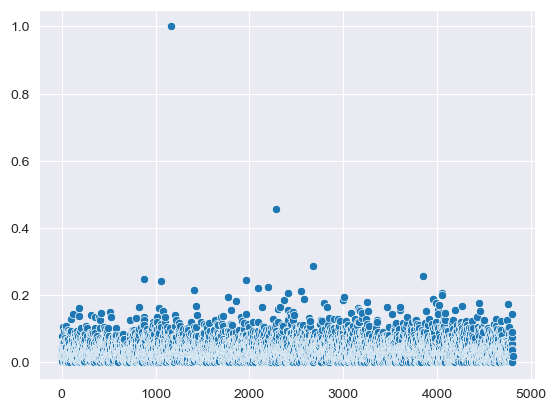

In [139]:
similarMovies = query(df, "Scream 3", vectorizer, vectorInputs, 15)
printMovieInfo(similarMovies)

lemmatizing: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.75it/s]

[   4 1735  373  473  487  270    0  754  778 1201 3668 2403  595 1319
 1959]
John Carter : Action Adventure Science Fiction
Ghosts of Mars : Action Horror Science Fiction
Mission to Mars : Science Fiction
Mars Attacks! : Comedy Fantasy Science Fiction
Red Planet : Thriller Action Science Fiction
The Martian : Drama Adventure Science Fiction
Avatar : Action Adventure Fantasy Science Fiction
Planet 51 : Science Fiction Animation Family Comedy Adventure
Meet Dave : Comedy Science Fiction Adventure Family
Predators : Action Science Fiction Adventure Thriller
Capricorn One : Drama Action Thriller Science Fiction
Aliens : Horror Action Thriller Science Fiction
Doom : Adventure Action Horror
Riddick : Science Fiction Action Thriller
Star Trek IV: The Voyage Home : Science Fiction Adventure


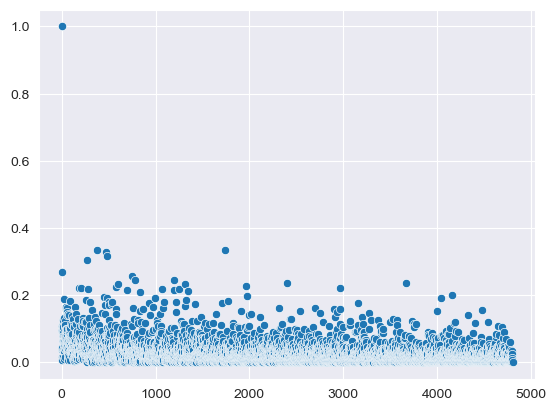

In [140]:
similarMovies = query(df, "John Carter", vectorizer, vectorInputs, 15)
printMovieInfo(similarMovies)

lemmatizing: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.69it/s]

[   4 1735  373  473  487  270    0  754  778 1201 3668 2403  595 1319
 1959]
John Carter : Action Adventure Science Fiction
Ghosts of Mars : Action Horror Science Fiction
Mission to Mars : Science Fiction
Mars Attacks! : Comedy Fantasy Science Fiction
Red Planet : Thriller Action Science Fiction
The Martian : Drama Adventure Science Fiction
Avatar : Action Adventure Fantasy Science Fiction
Planet 51 : Science Fiction Animation Family Comedy Adventure
Meet Dave : Comedy Science Fiction Adventure Family
Predators : Action Science Fiction Adventure Thriller
Capricorn One : Drama Action Thriller Science Fiction
Aliens : Horror Action Thriller Science Fiction
Doom : Adventure Action Horror
Riddick : Science Fiction Action Thriller
Star Trek IV: The Voyage Home : Science Fiction Adventure


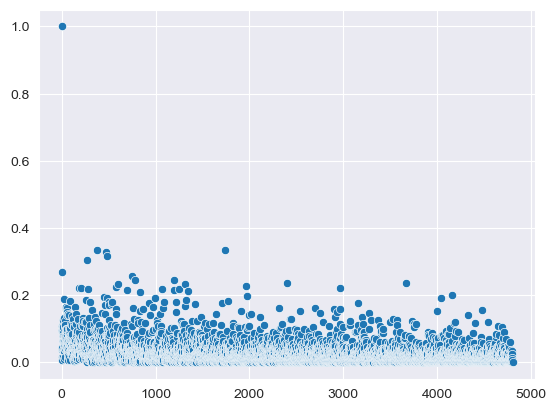

In [141]:
similarMovies = query(df, "John Carter", vectorizer, vectorInputs, 15)
printMovieInfo(similarMovies)

lemmatizing: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 247.76it/s]

[   0 2403  838 3158 1531 2015 4332  278 1914  461 3730 1213  184  778
  373]
Avatar : Action Adventure Fantasy Science Fiction
Aliens : Horror Action Thriller Science Fiction
Alien³ : Science Fiction Action Horror
Alien : Horror Action Thriller Science Fiction
Moonraker : Action Adventure Thriller Science Fiction
Spaceballs : Comedy Science Fiction
Silent Running : Adventure Drama Science Fiction
Planet of the Apes : Thriller Science Fiction Action Adventure
Lifeforce : Fantasy Horror Science Fiction Thriller
Lost in Space : Adventure Family Science Fiction
Cargo : Thriller Mystery Science Fiction
Aliens vs Predator: Requiem : Fantasy Action Science Fiction Thriller Horror
Home : Fantasy Comedy Animation Science Fiction Family
Meet Dave : Comedy Science Fiction Adventure Family
Mission to Mars : Science Fiction


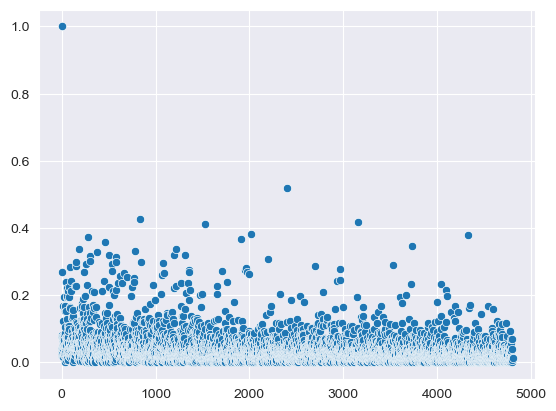

In [142]:
similarMovies = query(df, "Avatar", vectorizer, vectorInputs, 15)
printMovieInfo(similarMovies)